In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import warnings

warnings.filterwarnings("ignore")  # 경고 문구 생략

In [288]:
train_path = "../../data/train/"
test_path = "../../data/validation/"

train_label = pd.read_csv(train_path + "label/1.걸음걸이/training_label.csv")
train_sleep = pd.read_csv(train_path + "raw/train_sleep.csv")
train_activity = pd.read_csv(train_path + "raw/train_activity.csv")

test_label = pd.read_csv(test_path + "label/1.걸음걸이/val_label.csv")
test_sleep = pd.read_csv(test_path + "raw/val_sleep.csv")
test_activity = pd.read_csv(test_path + "raw/val_activity.csv")

In [289]:
random_seed = 42

In [290]:
label_encoder = {"CN": 0, "MCI": 1, "Dem": 2}

In [291]:
train_label["label"] = train_label["DIAG_NM"].map(label_encoder)
test_label["label"] = test_label["DIAG_NM"].map(label_encoder)
train_label.drop(columns=["DIAG_NM"], inplace=True)
test_label.drop(columns=["DIAG_NM"], inplace=True)

In [292]:
# label 과 합치기
train = train_sleep.merge(train_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")
test = test_sleep.merge(test_label, left_on="EMAIL", right_on="SAMPLE_EMAIL")

# sleep + activity
train = pd.concat([train, train_activity.drop(["EMAIL"], axis=1)], axis=1)
test = pd.concat([test, test_activity.drop(["EMAIL"], axis=1)], axis=1)

## 데이터 합치기

In [293]:
all_data = pd.concat([train, test], axis=0)
all_data = all_data.drop(["label"], axis=1)  # 타겟값 제거

# 데이터 전처리

## sleep_startpoint_at_delta 컬럼 추가

In [212]:
from datetime import datetime


# 자정과 timestamp의 차이(초)
def time_to_seconds_since_midnight(timestamp):
    dt = datetime.fromisoformat(timestamp[:-6])  # +09:00 타임존 offset 제거
    return dt.hour * 3600 + dt.minute * 60 + dt.second


all_data["sleep_startpoint_at_delta"] = all_data["sleep_bedtime_start"].apply(
    time_to_seconds_since_midnight
)

## startpoint_at_delta, midpoint_at_delta 자정 전의 시간이면 음수를 갖도록 수정

In [213]:
def adjust_delta_time(time):
    if time > 43200:
        time -= 86400
    return time


all_data["sleep_startpoint_at_delta_norm"] = all_data[
    "sleep_startpoint_at_delta"
].apply(adjust_delta_time)
all_data["sleep_midpoint_at_delta_norm"] = all_data["sleep_midpoint_at_delta"].apply(
    adjust_delta_time
)

## sleep_hr_5min, slee_rmssd_5min 결측치 선형보간

In [214]:
# 선형 보간 함수
def interpolate_zeros(lst):
    indices = np.arange(len(lst))  # 인덱스 배열 생성
    non_zero_indices = [i for i, x in enumerate(lst) if x != 0]  # 0이 아닌 값의 인덱스
    non_zero_values = [x for x in lst if x != 0]  # 0이 아닌 값들

    # 0이 아닌 값만을 기준으로 선형 보간
    interpolated_values = np.interp(indices, non_zero_indices, non_zero_values)

    return interpolated_values.tolist()

In [215]:
def get_log_list(log):
    log_list = list(map(int, log.rstrip("/").split("/")))
    return log_list

In [216]:
from joblib import Parallel, delayed

all_data["sleep_rmssd_5min_list"] = Parallel(n_jobs=-1)(
    delayed(get_log_list)(x) for x in all_data["CONVERT(sleep_rmssd_5min USING utf8)"]
)
all_data["sleep_hr_5min_list"] = Parallel(n_jobs=-1)(
    delayed(get_log_list)(x) for x in all_data["CONVERT(sleep_hr_5min USING utf8)"]
)
all_data["sleep_hypnogram_5min_list"] = Parallel(n_jobs=-1)(
    delayed(get_log_list)(x)
    for x in all_data["CONVERT(sleep_hypnogram_5min USING utf8)"]
)

# 병렬 처리로 interpolate_zeros 적용
all_data["sleep_rmssd_5min_list"] = Parallel(n_jobs=-1)(
    delayed(interpolate_zeros)(x) for x in all_data["sleep_rmssd_5min_list"]
)
all_data["sleep_hr_5min_list"] = Parallel(n_jobs=-1)(
    delayed(interpolate_zeros)(x) for x in all_data["sleep_hr_5min_list"]
)

# Feature Engineering

## sleep_consistency 파생 변수 생성

### bedtime_start, midpoint_at_delta 컬럼 sin, cos 변환

In [217]:
# 24시간 순환성을 가지도록
all_data["sleep_startpoint_at_delta_sin"] = np.sin(
    2 * np.pi * all_data["sleep_startpoint_at_delta_norm"] / 86400
)
all_data["sleep_startpoint_at_delta_cos"] = np.cos(
    2 * np.pi * all_data["sleep_startpoint_at_delta_norm"] / 86400
)

all_data["sleep_midpoint_at_delta_sin"] = np.sin(
    2 * np.pi * all_data["sleep_midpoint_at_delta_norm"] / 86400
)
all_data["sleep_midpoint_at_delta_cos"] = np.cos(
    2 * np.pi * all_data["sleep_midpoint_at_delta_norm"] / 86400
)

### 개인별 delta time sin, cos 벡터의 평균 길이 계산
- 모든 벡터가 동일한 방향(즉, 같은 시간대)에 있으면 평균 벡터 길이 = 1
- 시간 차이가 많이날수록 두 벡터의 평균 길이는 짧아짐

<br><br>

- 완벽한 consistency -> MRL = 1
- 일정하지 않은 패턴 -> MRL < 1
- 완전히 랜덤한 패턴 -> MRL = 0

In [218]:
all_data["sleep_startpoint_at_delta_sin_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_startpoint_at_delta_sin"
].cumsum()
all_data["sleep_startpoint_at_delta_cos_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_startpoint_at_delta_cos"
].cumsum()
all_data["sleep_midpoint_at_delta_sin_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_midpoint_at_delta_sin"
].cumsum()
all_data["sleep_midpoint_at_delta_cos_cumsum"] = all_data.groupby("EMAIL")[
    "sleep_midpoint_at_delta_cos"
].cumsum()
all_data["date_count"] = (
    all_data.groupby("EMAIL").cumcount() + 1
)  # cumcount 는 0부터 시작

In [219]:
# mrl: mean resultant length: 벡터들 평균 길이
all_data["sleep_startpoint_at_delta_mrl"] = (
    np.sqrt(
        all_data["sleep_startpoint_at_delta_sin_cumsum"] ** 2
        + all_data["sleep_startpoint_at_delta_cos_cumsum"] ** 2
    )
    / all_data["date_count"]
)
all_data["sleep_midpoint_at_delta_mrl"] = (
    np.sqrt(
        all_data["sleep_midpoint_at_delta_sin_cumsum"] ** 2
        + all_data["sleep_midpoint_at_delta_cos_cumsum"] ** 2
    )
    / all_data["date_count"]
)

### sleep_consistency

In [220]:
def fill_na_with_user_median(df, column_name):
    """
    shift, moving average 계산으로 비어있는 앞의 값 평균으로 채우기 개별 사용자의 중앙값으로 채운다.
    """
    # 사용자별 평균 계산
    user_medians = df.groupby("EMAIL")[column_name].transform("median")

    # NaN 값을 해당 사용자의 중앙값으로 채움
    df[column_name].fillna(user_medians, inplace=True)
    return df

In [221]:
def generate_time_lag_features(df, columns, lags=[2, 3], rolling_windows=[3, 7, 30]):
    """
    특정 컬럼(column)에 대해 Time Lag 변수와 이동 평균 변수를 생성하는 함수.

    Parameters:
    - df: DataFrame
    - columns: 타겟 컬럼명 리스트 (예: 'deep_ratio_5h' 또는 'awake_ratio_5h')
    - lags: Time Lag을 만들 간격 리스트 (기본값: [2, 3])
    - rolling_windows: 이동 평균을 계산할 윈도우 크기 리스트 (기본값: [3, 7, 30])

    Returns:
    - 변형된 DataFrame (원본 df에 새로운 컬럼 추가)
    """

    for column in columns:
        for lag in lags:
            df[f"{column}_lag{lag}"] = df.groupby("EMAIL")[column].shift(lag)
            df = fill_na_with_user_median(df, f"{column}_lag{lag}")

        for window in rolling_windows:
            df[f"{column}_{window}d_avg"] = df.groupby("EMAIL")[column].transform(
                lambda x: x.rolling(window, min_periods=1).mean()
            )
            df = fill_na_with_user_median(df, f"{column}_{window}d_avg")
    return df

In [222]:
all_data["sleep_consistency"] = (
    all_data["sleep_startpoint_at_delta_mrl"] + all_data["sleep_midpoint_at_delta_mrl"]
) / 2

all_data = generate_time_lag_features(all_data, ["sleep_consistency"])

In [224]:
derived_features = [col for col in all_data.columns if "consistency" in col]
derived_features += [col for col in all_data.columns if "_norm" in col]

## bedtime_start, bedtime_end 시간대, 요일 변수 추가

In [225]:
all_data["sleep_bedtime_start"] = pd.to_datetime(all_data["sleep_bedtime_start"])
all_data["sleep_bedtime_end"] = pd.to_datetime(all_data["sleep_bedtime_end"])

all_data["sleep_start_hour"] = all_data["sleep_bedtime_start"].dt.hour
all_data["sleep_start_weekday"] = all_data["sleep_bedtime_start"].dt.weekday

all_data["sleep_end_hour"] = all_data["sleep_bedtime_end"].dt.hour
all_data["sleep_end_weekday"] = all_data["sleep_bedtime_end"].dt.weekday

In [226]:
derived_features += [
    "sleep_start_hour",
    "sleep_start_weekday",
    "sleep_end_hour",
    "sleep_end_weekday",
]

In [227]:
derived_features

['sleep_consistency',
 'sleep_consistency_lag2',
 'sleep_consistency_lag3',
 'sleep_consistency_3d_avg',
 'sleep_consistency_7d_avg',
 'sleep_consistency_30d_avg',
 'sleep_startpoint_at_delta_norm',
 'sleep_midpoint_at_delta_norm',
 'sleep_start_hour',
 'sleep_start_weekday',
 'sleep_end_hour',
 'sleep_end_weekday']

## 수면 단계별 ratio

In [228]:
all_data["sleep_deep_ratio"] = all_data["sleep_deep"] / all_data["sleep_total"]
all_data["sleep_light_ratio"] = all_data["sleep_light"] / all_data["sleep_total"]
all_data["sleep_awake_ratio"] = all_data["sleep_awake"] / all_data["sleep_duration"]
all_data["sleep_rem_ratio"] = all_data["sleep_rem"] / all_data["sleep_total"]

all_data = generate_time_lag_features(
    all_data,
    ["sleep_deep_ratio", "sleep_light_ratio", "sleep_awake_ratio", "sleep_rem_ratio"],
)

In [229]:
derived_features += [col for col in all_data.columns if "_ratio" in col]

## 수면 초반 5시간 동안의 deep과 awake 비율, 최대 연속 깨어난 시간, 평균 깨어난 간격

In [230]:
def longest_consecutive_fours(nums):
    max_length = 0
    current_length = 0

    for num in nums:
        if num == 4:
            current_length += 1
            max_length = max(max_length, current_length)
        else:
            current_length = 0

    return max_length

In [231]:
def extract_features_from_hypnogram(hypnogram):
    # deep_ratio, awake_ratio 계산
    # 5시간(300분) 동안의 데이터만 사용 (5분 단위로 기록된 데이터이므로 60개의 데이터)
    hypnogram_60 = hypnogram[:60]
    deep_count = hypnogram_60.count("1")
    awake_count = hypnogram_60.count("4")
    total_count = len(hypnogram_60)
    deep_ratio = deep_count / total_count
    awake_ratio = awake_count / total_count

    # 깨어난 횟수, 평균 깨어난 간격
    awake_count = hypnogram.count(4)  # 깨어난 횟수 (4의 개수)
    max_awake_streak = longest_consecutive_fours(hypnogram)  # 최대 깨어난 연속 횟수
    # 평균 깨어난 간격 (전체 수면 시간에서 깨어난 횟수로 나눔, 단위: 초)
    awake_interval_avg = (len(hypnogram) * 300) / awake_count if awake_count > 0 else 0

    return (deep_ratio, awake_ratio, max_awake_streak, awake_interval_avg)


all_data[
    ["deep_ratio_5h", "awake_ratio_5h", "awake_longest_duration", "awake_interval_avg"]
] = (
    all_data["sleep_hypnogram_5min_list"]
    .apply(extract_features_from_hypnogram)
    .apply(pd.Series)
)

In [232]:
all_data = generate_time_lag_features(
    all_data,
    ["deep_ratio_5h", "awake_ratio_5h", "awake_longest_duration", "awake_interval_avg"],
)

In [ ]:
new_cols = [
    "deep_ratio_5h",
    "awake_ratio_5h",
    "awake_longest_duration",
    "awake_interval_avg",
]

for new_col in new_cols:
    derived_features += [col for col in all_data.columns if new_col in col]

## sleep_hr_lowest time_lag, moving average

In [235]:
all_data = generate_time_lag_features(all_data, ["sleep_hr_lowest"])

In [236]:
derived_features += [col for col in all_data.columns if "sleep_hr_lowest" in col]

## 심박수 패턴 파생변수

In [237]:
# 심박수 패턴 감지 함수 정의
def detect_patterns(hr_log, window_size=5):
    # hr_log를 numpy 배열로 변환
    hr_values = np.array(hr_log)

    # 이동 평균 계산
    moving_avg = np.convolve(
        hr_values, np.ones(window_size) / window_size, mode="valid"
    )

    # hammock pattern: 중간에 낮고 양쪽 끝이 높은 패턴
    if moving_avg[0] > moving_avg[len(moving_avg) // 2] < moving_avg[-1]:
        return 0

    # downward slope: 점진적으로 감소하는 패턴
    elif np.all(np.diff(moving_avg) < 0):
        return 1

    # the hill: 중간에 높고 양쪽 끝이 낮은 패턴
    elif moving_avg[0] < moving_avg[len(moving_avg) // 2] > moving_avg[-1]:
        return 3

    # the uplands: 점진적으로 증가하는 패턴
    elif np.all(np.diff(moving_avg) > 0):
        return 4

    return 5


# 심박수 패턴 파생변수 추가
all_data["hr_pattern"] = all_data["sleep_hr_5min_list"].apply(detect_patterns)

### 원 핫 인코딩

In [238]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoder를 사용하여 원핫인코딩 수행
encoder = OneHotEncoder(sparse=False)
encoded_patterns = encoder.fit_transform(all_data[["hr_pattern"]])

# 원핫인코딩 결과를 데이터프레임으로 변환
encoded_df = pd.DataFrame(
    encoded_patterns, columns=encoder.get_feature_names_out(["hr_pattern"])
).reset_index(drop=True)
all_data.reset_index(drop=True, inplace=True)

# 원본 데이터프레임과 원핫인코딩된 데이터프레임을 병합
all_data = pd.concat([all_data, encoded_df], axis=1)

In [240]:
derived_features += [col for col in all_data.columns if "hr_pattern_" in col]

## 파생변수 csv 저장

In [ ]:
# 'sleep_bedtime_end','sleep_bedtime_start','activity_day_end', 'activity_day_start'
derived_features += [
    col for col in all_data.columns if (("bedtime" in col) or ("day_" in col))
]
derived_features += ["EMAIL"]

In [247]:
derived_df = all_data[derived_features]
derived_df.to_csv("./data/case4_derived_features.csv", index=False)

## 파생변수 불러오기

In [285]:
derived_df = pd.read_csv("./data/case4_derived_features.csv")

In [294]:
date_columns = [
    "sleep_bedtime_end",
    "sleep_bedtime_start",
    "activity_day_end",
    "activity_day_start",
]

for col in date_columns:
    all_data[col] = pd.to_datetime(all_data[col])
    derived_df[col] = pd.to_datetime(derived_df[col])


all_data = all_data.merge(derived_df, on=["EMAIL"] + date_columns, how="left")

## 필요없는 피처 제거

In [295]:
drop_features = [
    "sleep_hr_5min",
    "sleep_rmssd_5min",
    "sleep_hypnogram_5min",
    "sleep_period_id",
    "sleep_is_longest",
    "sleep_rmssd",
    "sleep_score",
    "sleep_score_alignment",
    "sleep_temperature_delta",
    "sleep_temperature_deviation",
    "sleep_startpoint_at_delta_mrl",
    "sleep_midpoint_at_delta_mrl",
    "sleep_startpoint_at_delta_sin_cumsum",
    "sleep_startpoint_at_delta_cos_cumsum",
    "sleep_midpoint_at_delta_sin_cumsum",
    "sleep_midpoint_at_delta_sin_cumsum",
    "sleep_startpoint_at_delta_sin",
    "sleep_startpoint_at_delta_cos",
    "sleep_midpoint_at_delta_sin",
    "sleep_midpoint_at_delta_sin",
    "sleep_deep",
    "sleep_light",
    "sleep_awake",
    "sleep_rem",
    "sleep_efficiency",
    "sleep_score_efficiency",
    "sleep_score_deep",
    "sleep_score_rem",
    "sleep_score_light",
    "date_count",
    "sleep_total",
    "sleep_hr_pattern",
    "hr_pattern",
]

remaining_features = all_data.columns.difference(drop_features)
all_data = all_data[remaining_features]
all_data = all_data.select_dtypes(include=[int, float])  # 숫자형 데이터만
selected_features = all_data.columns


In [296]:
selected_features.values

array(['activity_average_met', 'activity_cal_active',
       'activity_cal_total', 'activity_daily_movement', 'activity_high',
       'activity_inactive', 'activity_inactivity_alerts', 'activity_low',
       'activity_medium', 'activity_met_min_high',
       'activity_met_min_inactive', 'activity_met_min_low',
       'activity_met_min_medium', 'activity_non_wear', 'activity_rest',
       'activity_score', 'activity_score_meet_daily_targets',
       'activity_score_move_every_hour', 'activity_score_recovery_time',
       'activity_score_stay_active', 'activity_score_training_frequency',
       'activity_score_training_volume', 'activity_steps',
       'activity_total', 'awake_interval_avg',
       'awake_interval_avg_30d_avg', 'awake_interval_avg_3d_avg',
       'awake_interval_avg_7d_avg', 'awake_interval_avg_lag2',
       'awake_interval_avg_lag3', 'awake_longest_duration',
       'awake_longest_duration_30d_avg', 'awake_longest_duration_3d_avg',
       'awake_longest_duration_7d_avg'

## 데이터 다운캐스팅

In [297]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2  # 1MB = 1024**2 Byte
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object":
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast="integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast="float")
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print("{:.1f}% 압축됨".format(100 * (start_mem - end_mem) / start_mem))

    return df


all_data = downcast(all_data)

65.7% 압축됨


## 데이터 스케일링

In [298]:
from sklearn.preprocessing import StandardScaler

all_data = StandardScaler().fit_transform(all_data)

## 데이터 나누기

In [299]:
num_train = len(train)

X = all_data[:num_train]
X_test = all_data[num_train:]

y = train["label"].values
y_test = test["label"].values

# SMOTE

Text(0, 0.5, 'Percentage (%)')

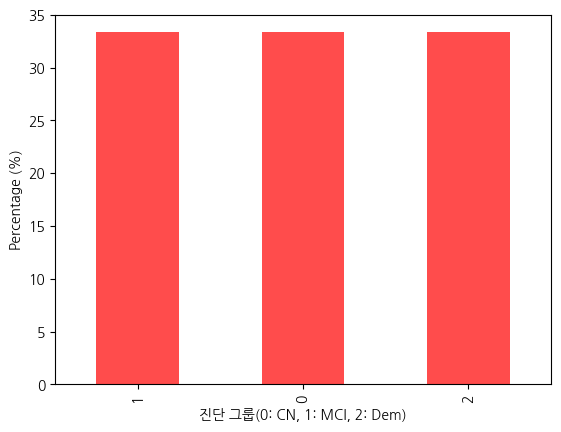

In [300]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=random_seed)
X_resampled, y_resampled = smote.fit_resample(X, y)

class_distribution_after = pd.Series(y_resampled).value_counts(normalize=True) * 100
class_distribution_after.plot(kind="bar", color="red", alpha=0.7)
plt.xlabel("진단 그룹(0: CN, 1: MCI, 2: Dem)")
plt.ylabel("Percentage (%)")

# 모델 훈련 및 성능 검증

In [301]:
n_splits = 5

In [302]:
from sklearn.model_selection import StratifiedKFold

# shuffle: 훈련 데이터가 시계열 데이터가 아니라면 섞어주는 것이 좋음
# 시계열 데이터는 순서가 중요해서 데이터를 섞으면 안도미
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

In [303]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(
        penalty="l1", solver="saga", multi_class="ovr"
    ),
    "Support Vector Machine": SVC(  # probability=False 모델 학습 시간 줄이기 위해
        kernel="linear", probability=False, random_state=random_seed
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=random_seed, warm_start=True
    ),
}

In [304]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
from joblib import Parallel, delayed

models_ = {}


def evaluate_model(name, model, folds, X_resampled, y_resampled):
    acc_scores = []
    f1_scores = []
    class_report_list = []

    for fold, (train_idx, val_idx) in enumerate(folds.split(X_resampled, y_resampled)):
        # 데이터 분할
        X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
        y_train, y_val = y_resampled[train_idx], y_resampled[val_idx]

        # 모델 학습
        model.fit(X_train, y_train)

        # 모델 예측
        y_pred = model.predict(X_val)

        # 평가
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average="weighted")  # 불균형 데이터 고려
        acc_scores.append(acc)
        f1_scores.append(f1)

        # Classification Report 저장
        report = classification_report(y_val, y_pred, output_dict=True)
        class_report_list.append(pd.DataFrame(report).T)

    # Classification Report 평균
    avg_class_report = pd.concat(class_report_list).groupby(level=0).mean()

    # Accuracy 및 F1-score 평균 출력
    print("#" * 40, f"Model: {name}", "#" * 40)
    print(f"=== Average Classification Report ===")
    print(avg_class_report)
    print(f"Average Accuracy: {np.mean(acc_scores):.4f}")
    print(f"Average F1-score: {np.mean(f1_scores):.4f}")
    print("=" * 60)

    return name, model


for name, model in models.items():
    name_, model_ = evaluate_model(name, model, folds, X_resampled, y_resampled)
    models_[name] = model

######################################## Model: Lasso Regression ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.609172  0.548004  0.576789  1156.200000
1              0.595860  0.608719  0.602170  1156.200000
2              0.779081  0.839647  0.808025  1156.200000
accuracy       0.665456  0.665456  0.665456     0.665456
macro avg      0.661371  0.665457  0.662328  3468.600000
weighted avg   0.661371  0.665456  0.662328  3468.600000
Average Accuracy: 0.6655
Average F1-score: 0.6623
######################################## Model: Support Vector Machine ########################################
=== Average Classification Report ===
              precision    recall  f1-score      support
0              0.633103  0.548695  0.587767  1156.200000
1              0.605573  0.672374  0.637140  1156.200000
2              0.825903  0.844319  0.834866  1156.200000
accuracy       0.688462  0.68

## test dataset 예측 결과

In [305]:
# Test Set 성능 평가
print("\n", "=" * 40, "TEST SET EVALUATION", "=" * 40, "\n")

for name, model in models_.items():
    print(f"=== Evaluating {name} on Test Set ===")

    # 테스트 데이터 예측
    y_test_pred = model.predict(X_test)

    # 테스트 데이터 평가
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")  # 불균형 고려
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # 결과 출력
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test Classification Report:\n", pd.DataFrame(test_report).T)
    print("=" * 60)


 ======================================== TEST SET EVALUATION ======================================== 

=== Evaluating Lasso Regression on Test Set ===
Test Accuracy: 0.5093
Test F1-score: 0.5646
Test Classification Report:
               precision    recall  f1-score      support
0              0.784285  0.540900  0.640242  1956.000000
1              0.113033  0.318182  0.166809   308.000000
2              0.404580  0.495327  0.445378   214.000000
accuracy       0.509282  0.509282  0.509282     0.509282
macro avg      0.433966  0.451470  0.417476  2478.000000
weighted avg   0.668061  0.509282  0.564569  2478.000000
=== Evaluating Support Vector Machine on Test Set ===
Test Accuracy: 0.4895
Test F1-score: 0.5516
Test Classification Report:
               precision    recall  f1-score      support
0              0.787832  0.516360  0.623842  1956.000000
1              0.103340  0.321429  0.156398   308.000000
2              0.436975  0.485981  0.460177   214.000000
accuracy       0.48